In [1]:
!pip3 install pywick

     |████████████████████████████████| 403 kB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 10.1 MB 4.9 MB/s eta 0:00:01
     |████████████████████████████████| 70 kB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 48 kB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 5.7 MB/s eta 0:00:01
     |████████████████████████████████| 510 kB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 177 kB 4.2 MB/s eta 0:00:01
  Created wheel for dill: filename=dill-0.3.2-py3-none-any.whl size=78912 sha256=e57da7e7806da3f9f00200e6959220c077206df848f765c9728f94b447124314
  Stored in directory: /Users/akshayanagarajan/Library/Caches/pip/wheels/93/7f/7d/78ec535a4340ef2696aad8b17fe8bb063d56301bd62881b069
Successfully built dill


/usr/local/lib/python3.8/site-packages/pywick/optimizers/nadam.py:79: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:766.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


Epoch [1/5], Step [100/600], Loss: 0.2491
Epoch [1/5], Step [200/600], Loss: 0.1088
Epoch [1/5], Step [300/600], Loss: 0.0794
Epoch [1/5], Step [400/600], Loss: 0.0238
Epoch [1/5], Step [500/600], Loss: 0.0921
Epoch [1/5], Step [600/600], Loss: 0.1080
Epoch [2/5], Step [100/600], Loss: 0.0651
Epoch [2/5], Step [200/600], Loss: 0.0485
Epoch [2/5], Step [300/600], Loss: 0.0288
Epoch [2/5], Step [400/600], Loss: 0.0410
Epoch [2/5], Step [500/600], Loss: 0.0589
Epoch [2/5], Step [600/600], Loss: 0.0216
Epoch [3/5], Step [100/600], Loss: 0.0139
Epoch [3/5], Step [200/600], Loss: 0.0561
Epoch [3/5], Step [300/600], Loss: 0.0624
Epoch [3/5], Step [400/600], Loss: 0.0120
Epoch [3/5], Step [500/600], Loss: 0.0232
Epoch [3/5], Step [600/600], Loss: 0.0379
Epoch [4/5], Step [100/600], Loss: 0.1303
Epoch [4/5], Step [200/600], Loss: 0.0494
Epoch [4/5], Step [300/600], Loss: 0.0131
Epoch [4/5], Step [400/600], Loss: 0.0877
Epoch [4/5], Step [500/600], Loss: 0.0307
Epoch [4/5], Step [600/600], Loss:

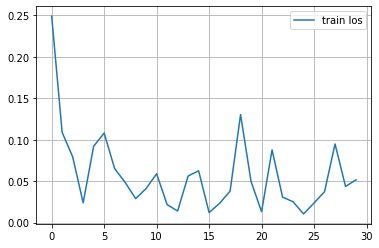

In [3]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from pywick.optimizers import nadam

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../../data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, dampening=0, nesterov=True)
optimizer = nadam.Nadam(model.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, schedule_decay=0.004)



# Train the model
total_step = len(train_loader)
train_log = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad() # Clear gradients w.r.t. parameters
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            train_log.append(loss.item())

# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

plt.plot(train_log,label='train los')
plt.legend(loc='best')
plt.grid()
plt.show()